In [4]:
import sys
sys.path.append('../')
from transformers import BertTokenizer, BertModel
import torch
import itertools
from collections import defaultdict
from probe.load_data import WordInspectionDataset, SentenceParaphraseInspectionDataset
from scipy.spatial.distance import cosine
from statistics import mean 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
def sentence_paraphrase_comparisons(tokenizer, feature_extraction_model, batch_size):
    pdata = SentenceParaphraseInspectionDataset('paraphrase_pair_vec_sim_test.txt', tokenizer)
    dataset = pdata.get_data()
    embedding_outputs, encoded_inputs, indices = pdata.bert_word_embeddings(feature_extraction_model,
                                                                            pdata.get_encoded(), batch_size)
    sentence_embeddings = pdata.aggregate_sentence_embeddings(embedding_outputs, encoded_inputs, indices,
                                                              aggregation_metric=torch.mean)

    paraphrase_pairs = get_paraphrase_pairs(dataset)
    paraphrase_cosine_metrics = [calculate_paraphrase_pair_similarity(pair_sents, tokenizer, dataset, embedding_outputs, encoded_inputs, sentence_embeddings) 
                            for pair_id, pair_sents in paraphrase_pairs.items()]
    
    return paraphrase_cosine_metrics

def word_similarity_comparisons(tokenizer, feature_extraction_model, batch_size):
    pdata = WordInspectionDataset('word_vec_sim_test.txt', tokenizer)
    dataset = pdata.get_data()
    embedding_outputs, encoded_inputs, _indices = pdata.bert_word_embeddings(feature_extraction_model,
                                                                            pdata.get_encoded(), batch_size)
    idiom_sentence_indexes = get_idiom_sentences(dataset)
    word_cosine_metrics = [calculate_word_similarity_metrics(idiom_sent_idx, tokenizer, dataset, embedding_outputs, encoded_inputs) 
                            for idiom_sent_idx in idiom_sentence_indexes]
    return word_cosine_metrics

def get_paraphrase_pairs(dataset):
    paraphrase_pairs = defaultdict(list)
    for i, sent in enumerate(dataset):
        paraphrase_pairs[sent.pair_id].append((i, sent))
    return paraphrase_pairs

def calculate_paraphrase_pair_similarity(pair, tokenizer, dataset, embedding_outputs, encoded_inputs, sentence_embeddings):
    sent_1 = pair[0]
    sent_2 = pair[1]
    sent_1_index = sent_1[0]
    sent_2_index = sent_2[0]
    cosine_sim = 1 - cosine(sentence_embeddings[sent_1_index], sentence_embeddings[sent_2_index])
    
    return {
        'pair_id': sent_1[1].pair_id,
        'sent_1': tokenizer.decode(encoded_inputs[sent_1_index].tolist()),
        'sent_2': tokenizer.decode(encoded_inputs[sent_2_index].tolist()),
        'paraphrase': dataset[sent_1_index].paraphrase,
        'judgment': dataset[sent_1_index].classifier_judgment,
        'cosine_similarity': cosine_sim
    }    

def calculate_word_similarity_metrics(idiom_sent_index, tokenizer, dataset, embedding_outputs, encoded_inputs):
    idiom_ex = dataset[idiom_sent_index]
    idiom_word_embedding = get_word_embedding(tokenizer, dataset, embedding_outputs, encoded_inputs, idiom_sent_index)
    cosine_similarity_metrics = {}

    literal_usage_sents = [i for i, ex in enumerate(dataset) if ex.pair_id == idiom_ex.pair_id and 
                                                            ex.word == idiom_ex.word and not 
                                                            ex.sentence_id == idiom_ex.sentence_id ]
    paraphrase_sents = [i for i, ex in enumerate(dataset) if ex.pair_id == idiom_ex.pair_id 
                                                            and not ex.word == idiom_ex.word]

    literal_usage_embeddings = [get_word_embedding(tokenizer, dataset, embedding_outputs, encoded_inputs, lit_idx) for lit_idx in literal_usage_sents]
    paraphrase_embeddings = [get_word_embedding(tokenizer, dataset, embedding_outputs, encoded_inputs, para_idx) for para_idx in paraphrase_sents]

    cosine_similarity_metrics['fig_to_literal'] = calculate_cosine_similarity_average([idiom_word_embedding], literal_usage_embeddings)
    cosine_similarity_metrics['literal_to_literal'] = calculate_cosine_similarity_average(literal_usage_embeddings)
    cosine_similarity_metrics['fig_to_paraphrase'] = calculate_cosine_similarity_average([idiom_word_embedding], paraphrase_embeddings)
    cosine_similarity_metrics['literal_to_paraphrase'] = calculate_cosine_similarity_average(literal_usage_embeddings, paraphrase_embeddings)
    
    return {
        'sentence_id': idiom_ex.sentence_id,
        'sentence': tokenizer.decode(encoded_inputs[idiom_sent_index].tolist()),
        'word': idiom_ex.word,
        'paraphrase_word': dataset[paraphrase_sents[0]].word,
        'cosine_similarities': cosine_similarity_metrics,
    }

def get_idiom_sentences(dataset):
    return [i for i, ex in enumerate(dataset) if ex.figurative]

def get_sentences_for_idiom_sentence(dataset, idiom_sent):
    literal_usage_sents = [i for i, ex in enumerate(dataset) if ex.pair_id == idiom_sent.pair_id and 
                                                                ex.word == idiom_sent.word and not 
                                                                ex.sentence_id == idiom_sent.sentence_id ]
    paraphrase_sents = [i for i, ex in enumerate(dataset) if ex.pair_id == idiom_sent.pair_id and not 
                                                            ex.word == idiom_sent.word]
    return (literal_usage_sents, paraphrase_sents)

def get_word_embedding(tokenizer, dataset, embedding_outputs, encoded_inputs, dataset_index):
    ex = dataset[dataset_index]
    decoded_tokens = tokenizer.convert_ids_to_tokens(encoded_inputs[dataset_index].tolist())
    word_index = decoded_tokens.index(ex.word[0])
    return embedding_outputs[dataset_index][word_index]

def calculate_cosine_similarity_average(embeddings_1, embeddings_2=None):
    if embeddings_2:
        embedding_pairs = list(itertools.product(embeddings_1, embeddings_2))
    else:
        embedding_pairs = list(itertools.combinations(embeddings_1, 2))

    cosine_similarities = [1 - cosine(embedding_1, embedding_2) for embedding_1, embedding_2 in embedding_pairs]
    return mean(cosine_similarities)

def summarize_word_similarity_comp(results):
    literal_sim_advantage = [result['cosine_similarities']['literal_to_literal'] - result['cosine_similarities']['fig_to_literal'] for result in results]
    fig_to_paraphrase_advantage = [result['cosine_similarities']['fig_to_paraphrase'] - result['cosine_similarities']['literal_to_paraphrase'] for result in results]
    
    summary_stats = {
        'lit_to_lit_cosine_improvement_over_fig_to_lit': mean(literal_sim_advantage),
        'fig_to_paraphrase_cosine_improvement_over_lit_to_paraphrase': mean(fig_to_paraphrase_advantage)
    }
    return summary_stats

def summarize_sentence_similarity_comp(results):
    correctly_judged_paraphrases = [result['cosine_similarity'] for result in results if result['paraphrase'] and result['judgment']]
    correctly_judged_non_paraphrases = [result['cosine_similarity'] for result in results if not result['paraphrase'] and not result['judgment']]
    incorrectly_judged_paraphrases =  [result['cosine_similarity'] for result in results if result['paraphrase'] and not result['judgment']]
    incorrectly_judged_non_paraphrases =  [result['cosine_similarity'] for result in results if not result['paraphrase'] and result['judgment']]

    return {
        'average_cosine_sim_for_correctly_judged_paraphrases': handle_zero_case(correctly_judged_paraphrases),
        'average_cosine_sim_for_correctly_judged_non_paraphrases': handle_zero_case(correctly_judged_non_paraphrases),
        'average_cosine_sim_for_incorrectly_judged_paraphrases': handle_zero_case(incorrectly_judged_paraphrases),
        'average_cosine_sim_for_incorrectly_judged_non_paraphrases': handle_zero_case(incorrectly_judged_non_paraphrases)
    }

def handle_zero_case(category_results):
    if not category_results:
        return 'N/A'
    return mean(category_results)

def word_PCA_fig_and_lit_comparisons(dataset, embedding_outputs, encoded_inputs):
    idiom_sentence_indexes = get_idiom_sentences(dataset)
    
    for idiom_sent_index in idiom_sentence_indexes:
        idiom_ex = dataset[idiom_sent_index]
        idiom_word_embedding = get_word_embedding(tokenizer, dataset, embedding_outputs, encoded_inputs, idiom_sent_index)
        cosine_similarity_metrics = {}

        literal_usage_sents = [i for i, ex in enumerate(dataset) if ex.pair_id == idiom_ex.pair_id and 
                                                                ex.word == idiom_ex.word and not 
                                                                ex.sentence_id == idiom_ex.sentence_id ]
        paraphrase_sents = [i for i, ex in enumerate(dataset) if ex.pair_id == idiom_ex.pair_id 
                                                                and not ex.word == idiom_ex.word]

        literal_usage_embeddings = [get_word_embedding(tokenizer, dataset, embedding_outputs, encoded_inputs, lit_idx) for lit_idx in literal_usage_sents]
        paraphrase_embeddings = [get_word_embedding(tokenizer, dataset, embedding_outputs, encoded_inputs, para_idx) for para_idx in paraphrase_sents]

        embeddings = literal_usage_embeddings + [idiom_word_embedding]
        labels =  np.array(len(literal_usage_embeddings) * [1] + [0])
        
        show_fig_and_lit_PCS(embeddings, labels, idiom_ex.word[0], idiom_ex.sentence)

def show_fig_and_lit_PCS(embeddings, labels, word, sentence):
    X = torch.stack(embeddings)
    pca = PCA(2)  
    projected = pca.fit_transform(X)
    target_names = ['figurative', 'literal']

    for color, i, target_name in zip(['turquoise', 'navy'], [0, 1], target_names):
        plt.scatter(projected[labels == i, 0], projected[labels == i, 1], color=color,  lw=2,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA for {}: Fig usage {}'.format(word, " ".join(sentence)))
    plt.show()
    
    
def word_PCA_paraphrase_comparisons(dataset, embedding_outputs, encoded_inputs):
    idiom_sentence_indexes = get_idiom_sentences(dataset)
    
    for idiom_sent_index in idiom_sentence_indexes:
        idiom_ex = dataset[idiom_sent_index]
        idiom_word_embedding = get_word_embedding(tokenizer, dataset, embedding_outputs, encoded_inputs, idiom_sent_index)
        cosine_similarity_metrics = {}

        literal_usage_sents = [i for i, ex in enumerate(dataset) if ex.pair_id == idiom_ex.pair_id and 
                                                                ex.word == idiom_ex.word and not 
                                                                ex.sentence_id == idiom_ex.sentence_id ]
        paraphrase_sents = [i for i, ex in enumerate(dataset) if ex.pair_id == idiom_ex.pair_id 
                                                                and not ex.word == idiom_ex.word]

        literal_usage_embeddings = [get_word_embedding(tokenizer, dataset, embedding_outputs, encoded_inputs, lit_idx) for lit_idx in literal_usage_sents]
        paraphrase_embeddings = [get_word_embedding(tokenizer, dataset, embedding_outputs, encoded_inputs, para_idx) for para_idx in paraphrase_sents]

        embeddings = literal_usage_embeddings + [idiom_word_embedding] + paraphrase_embeddings
        labels =  np.array(len(literal_usage_embeddings) * [1] + [0] + len(paraphrase_embeddings) * [2])
        
        show_PCS(embeddings, labels, idiom_ex.word[0], idiom_ex.sentence, dataset[paraphrase_sents[0]].word)

def show_PCS(embeddings, labels, word, sentence, paraphrase):
    X = torch.stack(embeddings)
    pca = PCA(2)  
    projected = pca.fit_transform(X)
    target_names = ['figurative', 'literal', 'paraphrase']

    for color, i, target_name in zip(['turquoise', 'navy', 'orangered'], [0, 1, 2], target_names):
        plt.scatter(projected[labels == i, 0], projected[labels == i, 1], color=color,  lw=2,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA for "{}" (Fig usage: "{}") Paraphrase word: {}'.format(word, " ".join(sentence), paraphrase))
    plt.show()

In [3]:
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased", do_lower_case=True)
feature_extraction_model = BertModel.from_pretrained('bert-large-uncased')
batch_size = 20  # totally arbitrarily chosen

In [5]:
word_sim_results = word_similarity_comparisons(tokenizer, feature_extraction_model, batch_size)

word_sim_results

processed 20/60 sentences, current max sentence length 21
processed 40/60 sentences, current max sentence length 22
processed 60/60 sentences, current max sentence length 22



[{'sentence_id': 1,
  'sentence': '[CLS] the cat is out of the bag. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
  'word': ['cat'],
  'paraphrase_word': ['secret'],
  'cosine_similarities': {'fig_to_literal': 0.8095400002267625,
   'literal_to_literal': 0.881085894174046,
   'fig_to_paraphrase': 0.5299287855625152,
   'literal_to_paraphrase': 0.5367808659871419}},
 {'sentence_id': 21,
  'sentence': "[CLS] soon we're going to hit the sack. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",
  'word': ['sack'],
  'paraphrase_word': ['bed'],
  'cosine_similarities': {'fig_to_literal': 0.5062072972456614,
   'literal_to_literal': 0.7760081390539805,
   'fig_to_paraphrase': 0.44221730828285216,
   'literal_to_paraphrase': 0.4630802833371692}},
 {'sentence_id': 41,
  'sentence': '[CLS] it is time to bite the bullet. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
  'word': ['bullet'],
  'paraphrase_word': ['si

In [6]:
word_cosine_summary_stats = summarize_word_similarity_comp(word_sim_results)

for label, stat in word_cosine_summary_stats.items():
    print(label + ": ", stat)

lit_to_lit_cosine_improvement_over_fig_to_lit:  0.16365623142984184
fig_to_paraphrase_cosine_improvement_over_lit_to_paraphrase:  -0.011361890810507333


In [7]:
sentence_sim_results = sentence_paraphrase_comparisons(tokenizer, feature_extraction_model, batch_size)

sentence_sim_results

processed 10/10 sentences, current max sentence length 14



[{'pair_id': 1,
  'sent_1': '[CLS] the cat is out of the bag. [SEP] [PAD] [PAD] [PAD] [PAD]',
  'sent_2': '[CLS] it is no longer a secret. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]',
  'paraphrase': 1,
  'judgment': 1,
  'cosine_similarity': 0.796942412853241},
 {'pair_id': 2,
  'sent_1': "[CLS] soon we're going to hit the sack. [SEP] [PAD] [PAD]",
  'sent_2': "[CLS] we'll go to bed before long. [SEP] [PAD] [PAD] [PAD]",
  'paraphrase': 1,
  'judgment': 1,
  'cosine_similarity': 0.780309796333313},
 {'pair_id': 3,
  'sent_1': '[CLS] it is time to bite the bullet. [SEP] [PAD] [PAD] [PAD] [PAD]',
  'sent_2': '[CLS] the situation, though unpleasant, must be addressed. [SEP] [PAD] [PAD]',
  'paraphrase': 1,
  'judgment': 0,
  'cosine_similarity': 0.6908389925956726},
 {'pair_id': 4,
  'sent_1': '[CLS] she will be there at the drop of a hat. [SEP] [PAD]',
  'sent_2': "[CLS] instantly she'll be there. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]",
  'paraphrase': 1,
  'judgment': 0,
  'cosine_similarity': 

In [8]:
summarize_sentence_similarity_comp(sentence_sim_results)

{'average_cosine_sim_for_correctly_judged_paraphrases': 0.788626104593277,
 'average_cosine_sim_for_correctly_judged_non_paraphrases': 'N/A',
 'average_cosine_sim_for_incorrectly_judged_paraphrases': 0.7999201615651449,
 'average_cosine_sim_for_incorrectly_judged_non_paraphrases': 'N/A'}

In [9]:
# PCA visualizations

In [10]:
pdata = WordInspectionDataset('word_vec_sim_test.txt', tokenizer)
dataset = pdata.get_data()
embedding_outputs, encoded_inputs, _indices = pdata.bert_word_embeddings(feature_extraction_model,
                                                                        pdata.get_encoded(), batch_size)

processed 20/60 sentences, current max sentence length 21
processed 40/60 sentences, current max sentence length 22
processed 60/60 sentences, current max sentence length 22



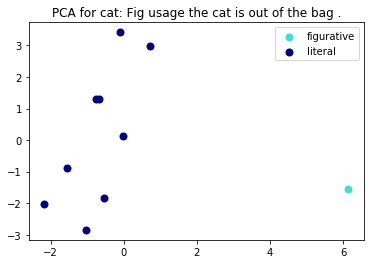

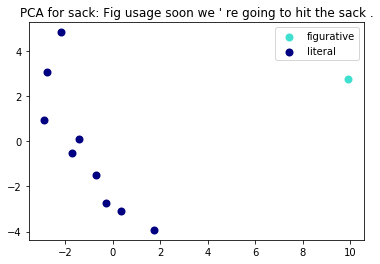

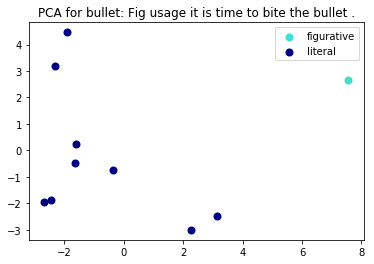

In [11]:
word_PCA_fig_and_lit_comparisons(dataset, embedding_outputs, encoded_inputs)

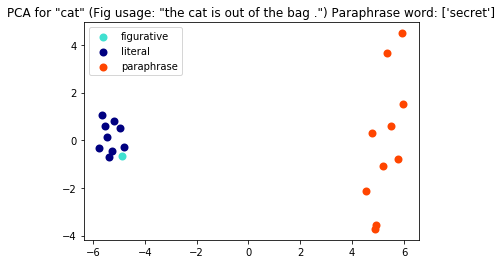

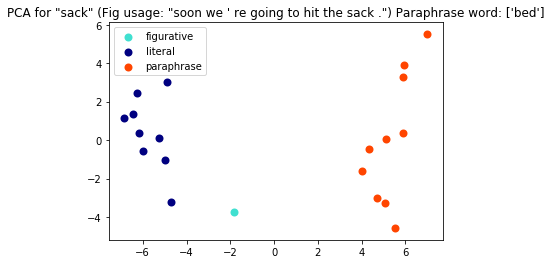

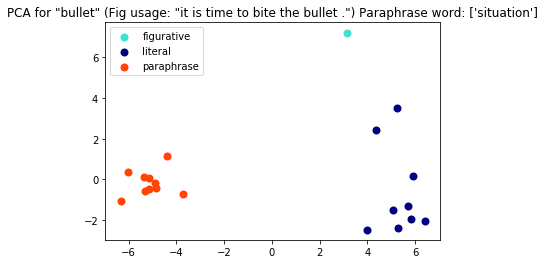

In [12]:
word_PCA_paraphrase_comparisons(dataset, embedding_outputs, encoded_inputs)